# Predicting Income with Census Data: Modeling

Rafael G. Guerra | April 2022

We will be comparing the performance of two popular models for Machine learning: (1) logistic regression, and (2) random forests. We will be using Logistic Regressions, Grid Search, Normalization techniques, and SMOTE.

## Import Libraries

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import pandas as pd
import numpy as np

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

## Import Data

In [70]:
train_data = pd.read_csv('train_eda.csv')
test_data = pd.read_csv('test_eda.csv')

## Logistic Regression

We will first try a simple classification algorithm -- logistic regression. We will split the data into the X component (all features) and the y compontent (the target variable, INCOME). We can then evaluate the model through its confusion matric and AUC (area under the curve)

In [73]:
data_train = train_data.values
data_test = test_data.values

In [74]:
X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_test[:, :-1], data_test[:, -1]

### Parameter Choices

Usually, I would run GridSearchCV and try several parameter combinations to maximize accuracy. However, given the size of the datasets, it is a computationally expensive operation for this exercise and instead I will only try different solvers and different penalties, since from experience, these are two of the biggest factors that may lead to different performances in a logistic regression

In [75]:
solvers = ['lbfgs','liblinear','sag','saga']
for solver in solvers:
    model = LogisticRegression(random_state=0,solver=solver).fit(X_train, y_train)
    print(solver,model.score(X_test,y_test))

lbfgs 0.9444778573003749
liblinear 0.9518854874601552
sag 0.9422826326657445
saga 0.9420921793869409


In [76]:
penalties = ['l1', 'l2']
for penalty in penalties:
    model = LogisticRegression(solver='liblinear',penalty=penalty).fit(X_train, y_train)
    print(penalty,model.score(X_test,y_test))

l1 0.9518453920330386
l2 0.9518854874601552


In [77]:
logReg = LogisticRegression(solver='liblinear',penalty='l2').fit(X_train, y_train)

### Accuracy

Very good accuracy!

In [78]:
logReg.score(X_test, y_test)

0.9518854874601552

### ROC Curve

Very good ROC!

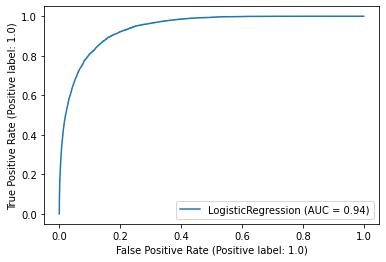

In [79]:
metrics.plot_roc_curve(logReg, X_test, y_test) 

### AUC (Area Under Curve)

Very good AUC!

In [81]:
metrics.roc_auc_score(y_test, logReg.predict_proba(X_test)[:, 1])

0.9406543014143552

### Confusion Matrix

A-ha! We have a serious problem with imbalanced data. The model has a ridiculously high accuracy because it does a great job at predicting most people don't make 50,000. But when we look at the number of people that do make 50,000, the model didn't do such a great job of picking that up.

In [82]:
predictions = logReg.predict(X_test)

In [83]:
cm = metrics.confusion_matrix(y_test, predictions)

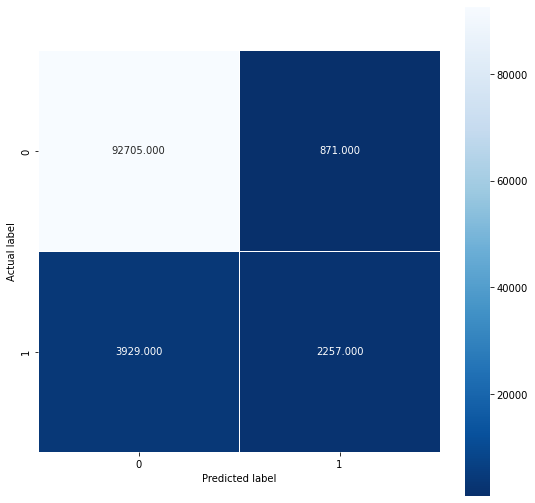

In [84]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

### Balancing Data with SMOTE

In [85]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

In [86]:
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_balanced))

Resampled dataset shape Counter({0.0: 187141, 1.0: 187141})


In [87]:
logReg_balanced = LogisticRegression(solver='liblinear',penalty='l2').fit(X_train_balanced, y_train_balanced)

### Accuracy, AUC, ROC, and Confusion Matrix

Accuracy:  0.8369820172009382
AUC:  0.9335613550328243


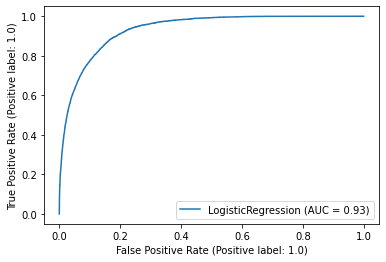

In [89]:
print('Accuracy: ', logReg_balanced.score(X_test, y_test))
print('AUC: ' , metrics.roc_auc_score(y_test, logReg_balanced.predict_proba(X_test)[:, 1]))
metrics.plot_roc_curve(logReg_balanced, X_test, y_test) 

In [90]:
predictions = logReg_balanced.predict(X_test)

In [91]:
cm_balanced = metrics.confusion_matrix(y_test, predictions)

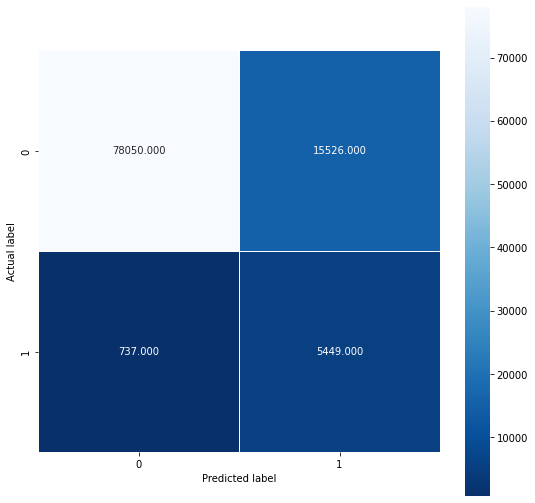

In [92]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_balanced, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

### Which model to pick?

This is where a discussion with the client would come in handy! If it's more important for the client to correctly predict that someone makes 50,000, I would pick the second model because it does a much better job of predicting who actually makes 50,000 and above. However, if the client cares equally about predicting both those who make 50,000 and those that don't, I would go with the first model because it has a higher overall accuracy. For now, I will stick with the first model which had a higher accuracy.

### What are the most predictive variables?

In [94]:
train_data_columns = []
for column in train_data:
    train_data_columns.append(column)
del train_data_columns[-1]

log_odds = logReg.coef_[0]
pd.DataFrame(log_odds, 
             train_data_columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
AHGA_ Prof school degree (MD DDS DVM LLB JD),2.194286
AHGA_ Doctorate degree(PhD EdD),2.100697
ACLSWKR_ Self-employed-incorporated,1.444214
AHGA_ Masters degree(MA MS MEng MEd MSW MBA),1.381821
AMJOCC_ Executive admin and managerial,1.201763
AMJOCC_ Professional specialty,0.911077
AHGA_ Bachelors degree(BA AB BS),0.875611
AMJIND_ Public administration,0.778865
ACLSWKR_ Self-employed-not incorporated,0.749511
ACLSWKR_ Not in universe,0.722131


### Sanity Check

According to the logistic regression model, education and highest schooling level are the strongest predictors of income. Those with MD, JDs, and phDs, in particular are more likely to make above 50,000. On the other hand, women, those who live with their parenets, those who do not have a tax filing status, and those who were under 18 were less likely to make 50,000 or above. Overall, I would say the model passes the sanity check, even if some of its conclusions can be a little depressing.